# Risk Assessment & Business Impact Scoring

This notebook creates a comprehensive risk assessment system for F&B business location selection in Bandung.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

## Load Trained Model and Data

In [2]:
# Load the best trained model
try:
    model = joblib.load('../models/best_model.pkl')
    scaler = joblib.load('../models/scaler.pkl')
    print("✅ Model and scaler loaded successfully")
except:
    print("❌ Model not found. Please run model_development.ipynb first")

# Load feature names
try:
    with open('../models/feature_names.txt', 'r') as f:
        feature_names = [line.strip() for line in f.readlines()]
    print(f"✅ Feature names loaded: {len(feature_names)} features")
except:
    print("❌ Feature names not found")

# Load dataset
df = pd.read_csv('../datasets/final_training_dataset.csv')
print(f"✅ Dataset loaded: {df.shape}")

✅ Model and scaler loaded successfully
✅ Feature names loaded: 13 features
✅ Dataset loaded: (31, 9)


## Risk Scoring Framework

In [8]:
class BusinessRiskAssessment:
    def __init__(self, model, scaler, feature_names):
        self.model = model
        self.scaler = scaler
        self.feature_names = feature_names
        
    def predict_rating(self, location_data):
        """
        Predict business rating for given location data
        """
        # Ensure features are in correct order
        features = location_data[self.feature_names]
        
        # Scale if needed (for linear models)
        try:
            features_scaled = self.scaler.transform([features])
            prediction = self.model.predict(features_scaled)[0]
        except:
            # For tree-based models that don't need scaling
            prediction = self.model.predict([features])[0]
            
        return prediction
    
    def calculate_risk_score(self, predicted_rating, market_saturation, competition_density):
        """
        Calculate comprehensive risk score based on multiple factors
        """
        # Base risk from predicted rating (inverse relationship)
        rating_risk = (5.0 - predicted_rating) / 4.0  # Normalize to 0-1
        
        # Market saturation risk (high fnb_per_capita = high risk)
        saturation_risk = min(market_saturation * 1000, 1.0)  # Cap at 1.0
        
        # Competition density risk (high fnb_per_km2 = high risk)
        competition_risk = min(competition_density / 10, 1.0)  # Cap at 1.0
        
        # Weighted composite risk score
        composite_risk = (
            0.5 * rating_risk +      # 50% weight on predicted performance
            0.3 * saturation_risk +  # 30% weight on market saturation
            0.2 * competition_risk   # 20% weight on competition density
        )
        
        return min(composite_risk, 1.0)  # Ensure risk doesn't exceed 1.0
    
    def get_risk_category(self, risk_score):
        """
        Categorize risk level
        """
        if risk_score <= 0.3:
            return "LOW RISK", "🟢"
        elif risk_score <= 0.6:
            return "MEDIUM RISK", "🟡"
        else:
            return "HIGH RISK", "🔴"
    
    def generate_recommendations(self, risk_score, predicted_rating, location_data):
        """
        Generate business recommendations based on risk assessment
        """
        recommendations = []
        
        # Rating-based recommendations
        if predicted_rating < 3.5:
            recommendations.append("⚠️ Focus on exceptional food quality and service")
            recommendations.append("📈 Consider unique value proposition to stand out")
        
        # Market saturation recommendations
        if location_data.get('fnb_per_capita', 0) > 0.001:  # High saturation
            recommendations.append("🎯 Differentiate with specialized cuisine or concept")
            recommendations.append("💰 Competitive pricing strategy essential")
        
        # Competition density recommendations
        if location_data.get('fnb_per_km2', 0) > 5:  # High competition
            recommendations.append("🚀 Strong marketing and branding required")
            recommendations.append("⭐ Exceptional customer experience crucial")
        
        # Population-based recommendations
        if location_data.get('Jumlah Penduduk', 0) < 50000:  # Low population
            recommendations.append("📍 Consider targeting tourists or office workers")
            recommendations.append("🎪 Host events to attract customers from nearby areas")
        
        # General recommendations based on risk level
        if risk_score > 0.6:
            recommendations.append("🛡️ Consider alternative locations or business models")
            recommendations.append("💼 Ensure strong financial reserves for initial period")
        elif risk_score < 0.3:
            recommendations.append("✅ Good location fundamentals - focus on execution")
            recommendations.append("📊 Monitor market trends for expansion opportunities")
        
        return recommendations

# Initialize the risk assessment system
risk_assessor = BusinessRiskAssessment(model, scaler, feature_names)
print("✅ Risk Assessment System initialized")

✅ Risk Assessment System initialized


## Analyze Current Dataset Locations

In [9]:
# Add risk scores to the dataset
df_analysis = df.copy()

# Calculate risk scores for all locations
risk_scores = []
predicted_ratings = []

for idx, row in df_analysis.iterrows():
    try:
        # Get prediction
        pred_rating = risk_assessor.predict_rating(row)
        predicted_ratings.append(pred_rating)
        
        # Calculate risk score
        market_saturation = row.get('fnb_per_capita', 0)
        competition_density = row.get('fnb_per_km2', 0)
        
        risk_score = risk_assessor.calculate_risk_score(
            pred_rating, market_saturation, competition_density
        )
        risk_scores.append(risk_score)
        
    except Exception as e:
        # Handle missing features
        predicted_ratings.append(3.0)  # Default rating
        risk_scores.append(0.5)  # Medium risk

df_analysis['predicted_rating'] = predicted_ratings
df_analysis['risk_score'] = risk_scores
df_analysis['risk_category'] = df_analysis['risk_score'].apply(
    lambda x: risk_assessor.get_risk_category(x)[0]
)

print(f"✅ Risk analysis completed for {len(df_analysis)} locations")

✅ Risk analysis completed for 31 locations


## Risk Distribution Analysis

In [10]:
# Risk distribution summary
risk_summary = df_analysis['risk_category'].value_counts()
print("Risk Distribution:")
print(risk_summary)
print(f"\nRisk Statistics:")
print(f"Mean Risk Score: {df_analysis['risk_score'].mean():.3f}")
print(f"Median Risk Score: {df_analysis['risk_score'].median():.3f}")
print(f"Std Risk Score: {df_analysis['risk_score'].std():.3f}")

Risk Distribution:
risk_category
MEDIUM RISK    31
Name: count, dtype: int64

Risk Statistics:
Mean Risk Score: 0.500
Median Risk Score: 0.500
Std Risk Score: 0.000


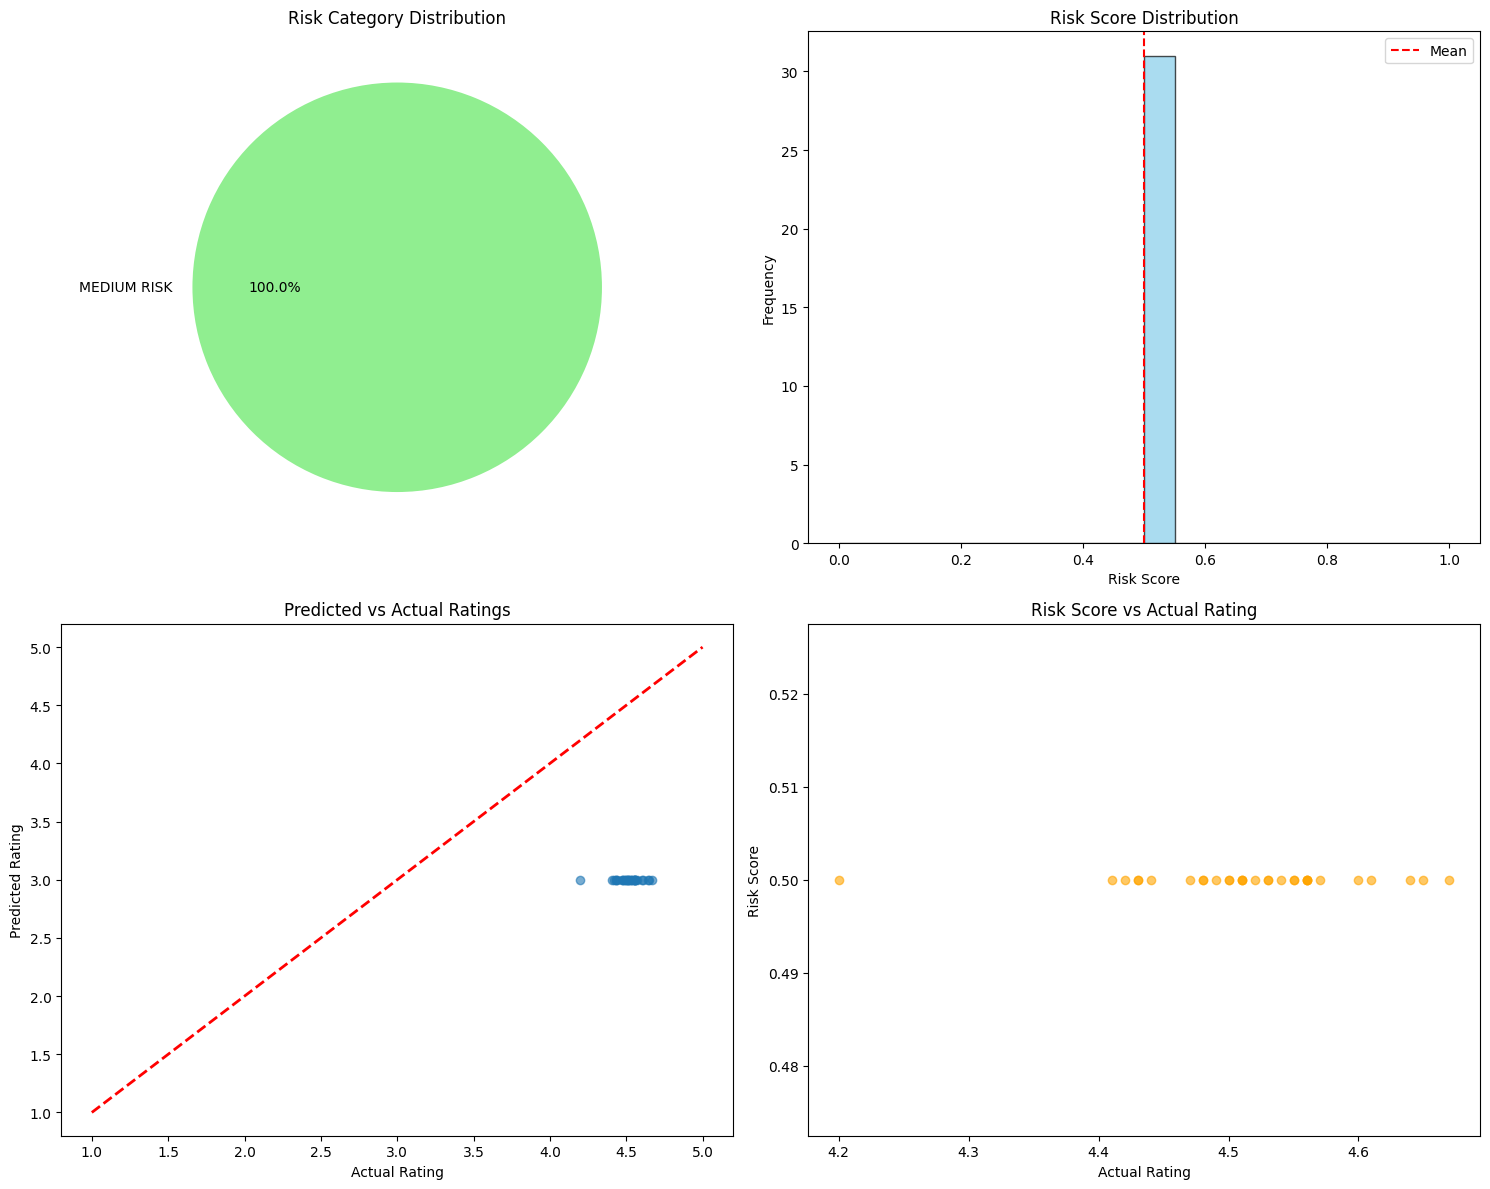

In [11]:
# Visualize risk distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Risk category distribution
axes[0, 0].pie(risk_summary.values, labels=risk_summary.index, autopct='%1.1f%%', 
               colors=['lightgreen', 'gold', 'lightcoral'])
axes[0, 0].set_title('Risk Category Distribution')

# Risk score histogram
axes[0, 1].hist(df_analysis['risk_score'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 1].set_xlabel('Risk Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Risk Score Distribution')
axes[0, 1].axvline(df_analysis['risk_score'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 1].legend()

# Predicted vs Actual Rating
axes[1, 0].scatter(df_analysis['avg_rating'], df_analysis['predicted_rating'], alpha=0.6)
axes[1, 0].plot([1, 5], [1, 5], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual Rating')
axes[1, 0].set_ylabel('Predicted Rating')
axes[1, 0].set_title('Predicted vs Actual Ratings')

# Risk Score vs Actual Rating
axes[1, 1].scatter(df_analysis['avg_rating'], df_analysis['risk_score'], alpha=0.6, color='orange')
axes[1, 1].set_xlabel('Actual Rating')
axes[1, 1].set_ylabel('Risk Score')
axes[1, 1].set_title('Risk Score vs Actual Rating')

plt.tight_layout()
plt.savefig('../results/Risk_Analysis_Overview.png', dpi=300, bbox_inches='tight')
plt.show()

## Kecamatan-Level Risk Analysis

In [12]:
# Aggregate risk by kecamatan
kecamatan_risk = df_analysis.groupby('kecamatan').agg({
    'risk_score': ['mean', 'std', 'count'],
    'avg_rating': 'mean',
    'predicted_rating': 'mean',
    'fnb_per_capita': 'mean',
    'fnb_per_km2': 'mean'
}).round(3)

kecamatan_risk.columns = ['avg_risk_score', 'risk_std', 'business_count', 
                         'avg_actual_rating', 'avg_predicted_rating',
                         'market_saturation', 'competition_density']

# Sort by average risk score
kecamatan_risk = kecamatan_risk.sort_values('avg_risk_score')

print("Kecamatan Risk Analysis (Top 10 Lowest Risk):")
print(kecamatan_risk.head(10))

print("\nKecamatan Risk Analysis (Top 10 Highest Risk):")
print(kecamatan_risk.tail(10))

KeyError: "Column(s) ['fnb_per_capita', 'fnb_per_km2'] do not exist"

In [ ]:
# Visualize kecamatan risk levels
plt.figure(figsize=(14, 8))
top_kecamatan = kecamatan_risk.head(15)  # Top 15 lowest risk

colors = ['green' if x <= 0.3 else 'orange' if x <= 0.6 else 'red' 
          for x in top_kecamatan['avg_risk_score']]

bars = plt.bar(range(len(top_kecamatan)), top_kecamatan['avg_risk_score'], 
               color=colors, alpha=0.7)

plt.xlabel('Kecamatan')
plt.ylabel('Average Risk Score')
plt.title('Average Risk Score by Kecamatan (Top 15 Lowest Risk)')
plt.xticks(range(len(top_kecamatan)), top_kecamatan.index, rotation=45, ha='right')

# Add risk threshold lines
plt.axhline(y=0.3, color='green', linestyle='--', alpha=0.7, label='Low Risk Threshold')
plt.axhline(y=0.6, color='orange', linestyle='--', alpha=0.7, label='Medium Risk Threshold')

plt.legend()
plt.tight_layout()
plt.savefig('../results/Kecamatan_Risk_Analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Interactive Risk Assessment Function

In [ ]:
def assess_location_risk(jumlah_penduduk, luas_wilayah, kepadatan_jiwa, 
                        jumlah_fnb, jumlah_taman, avg_price,
                        jumlah_shopping_place=0, jumlah_universitas=0):
    """
    Comprehensive location risk assessment function
    """
    # Create location data dictionary
    location_data = {
        'Jumlah Penduduk': jumlah_penduduk,
        'Luas Wilayah': luas_wilayah,
        'Kepadatan Jiwa': kepadatan_jiwa,
        'jumlah_fnb': jumlah_fnb,
        'jumlah_taman': jumlah_taman,
        'avg_price': avg_price,
        'jumlah_shopping_place': jumlah_shopping_place,
        'jumlah_universitas': jumlah_universitas
    }
    
    # Calculate derived features
    location_data['fnb_per_capita'] = jumlah_fnb / jumlah_penduduk
    location_data['fnb_per_km2'] = jumlah_fnb / luas_wilayah
    location_data['taman_per_capita'] = jumlah_taman / jumlah_penduduk
    
    # Estimate productive population (65% assumption)
    location_data['jumlah_penduduk_usia_produktif'] = jumlah_penduduk * 0.65
    location_data['penduduk_produktif_ratio'] = 0.65
    
    try:
        # Get prediction
        predicted_rating = risk_assessor.predict_rating(pd.Series(location_data))
        
        # Calculate risk score
        risk_score = risk_assessor.calculate_risk_score(
            predicted_rating,
            location_data['fnb_per_capita'],
            location_data['fnb_per_km2']
        )
        
        # Get risk category
        risk_category, risk_emoji = risk_assessor.get_risk_category(risk_score)
        
        # Generate recommendations
        recommendations = risk_assessor.generate_recommendations(
            risk_score, predicted_rating, location_data
        )
        
        # Print results
        print("" + "="*60)
        print("🏪 BUSINESS LOCATION RISK ASSESSMENT REPORT")
        print("="*60)
        print(f"📍 Location Demographics:")
        print(f"   Population: {jumlah_penduduk:,}")
        print(f"   Area: {luas_wilayah:.2f} km²")
        print(f"   Population Density: {kepadatan_jiwa:,} people/km²")
        print(f"   Existing F&B: {jumlah_fnb}")
        print(f"   Parks: {jumlah_taman}")
        print(f"   Average Price: Rp {avg_price:,}")
        
        print(f"\n📊 Market Analysis:")
        print(f"   F&B per 1000 people: {location_data['fnb_per_capita']*1000:.2f}")
        print(f"   F&B density: {location_data['fnb_per_km2']:.2f} per km²")
        print(f"   Parks per 1000 people: {location_data['taman_per_capita']*1000:.2f}")
        
        print(f"\n🎯 AI Predictions:")
        print(f"   Expected Rating: {predicted_rating:.2f}/5.0 ⭐")
        print(f"   Risk Score: {risk_score:.3f}")
        print(f"   Risk Level: {risk_emoji} {risk_category}")
        
        print(f"\n💡 Recommendations:")
        for i, rec in enumerate(recommendations, 1):
            print(f"   {i}. {rec}")
        
        print("="*60)
        
        return {
            'predicted_rating': predicted_rating,
            'risk_score': risk_score,
            'risk_category': risk_category,
            'recommendations': recommendations,
            'location_data': location_data
        }
        
    except Exception as e:
        print(f"❌ Error in risk assessment: {e}")
        return None

print("✅ Interactive risk assessment function ready")

## Example Risk Assessments

In [ ]:
# Example 1: High-density urban area (like Coblong)
print("Example 1: High-Density Urban Area")
result1 = assess_location_risk(
    jumlah_penduduk=120000,
    luas_wilayah=8.5,
    kepadatan_jiwa=14000,
    jumlah_fnb=85,
    jumlah_taman=5,
    avg_price=45000,
    jumlah_shopping_place=15,
    jumlah_universitas=3
)

In [ ]:
# Example 2: Medium-density suburban area
print("\nExample 2: Medium-Density Suburban Area")
result2 = assess_location_risk(
    jumlah_penduduk=75000,
    luas_wilayah=12.0,
    kepadatan_jiwa=6250,
    jumlah_fnb=25,
    jumlah_taman=8,
    avg_price=35000,
    jumlah_shopping_place=8,
    jumlah_universitas=1
)

In [ ]:
# Example 3: Low-density area with potential
print("\nExample 3: Low-Density Area with Growth Potential")
result3 = assess_location_risk(
    jumlah_penduduk=45000,
    luas_wilayah=15.0,
    kepadatan_jiwa=3000,
    jumlah_fnb=12,
    jumlah_taman=6,
    avg_price=28000,
    jumlah_shopping_place=4,
    jumlah_universitas=0
)

## Save Risk Assessment System

In [ ]:
# Save the risk assessment results
df_analysis[['kecamatan', 'avg_rating', 'predicted_rating', 'risk_score', 'risk_category']].to_csv(
    '../results/location_risk_assessment.csv', index=False
)

# Save kecamatan-level analysis
kecamatan_risk.to_csv('../results/kecamatan_risk_analysis.csv')

# Create a comprehensive risk assessment guide
guide = """
=== AI BUSINESS IMPACT PREDICTOR - USER GUIDE ===

RISK SCORING SYSTEM:
• LOW RISK (0.0-0.3): 🟢 Favorable conditions for F&B business
• MEDIUM RISK (0.3-0.6): 🟡 Moderate challenges, manageable with good strategy
• HIGH RISK (0.6-1.0): 🔴 Significant challenges, consider alternative locations

KEY FACTORS ANALYZED:
1. Predicted Business Rating (50% weight)
2. Market Saturation - F&B per capita (30% weight)
3. Competition Density - F&B per km² (20% weight)

HOW TO USE:
1. Gather location demographic data
2. Use assess_location_risk() function
3. Review predicted rating and risk score
4. Follow tailored recommendations

RECOMMENDATIONS COVER:
• Food quality and service standards
• Market positioning and differentiation
• Pricing strategy
• Marketing and branding
• Target customer segments
• Financial planning considerations

For technical support or model updates, refer to the model development documentation.
"""

with open('../results/risk_assessment_guide.txt', 'w') as f:
    f.write(guide)

print("✅ Risk assessment system and documentation saved successfully!")
print("\n📁 Files created:")
print("   • ../results/location_risk_assessment.csv")
print("   • ../results/kecamatan_risk_analysis.csv")
print("   • ../results/risk_assessment_guide.txt")
print("   • ../results/Risk_Analysis_Overview.png")
print("   • ../results/Kecamatan_Risk_Analysis.png")